# Project: Investigate the TMDb movie data

## Question: What are key features of movies with a high vote average?


### Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

This data set contains metadata (such as title, director, keywords, revenue and user ratings) on around 10,000 movies collected from The Movie Database (TMDb). The data are originally from Kaggle but were cleaned before they were provided for this project.

In this project we want to understand what factors correlate with the average vote score for movies in the dataset. **vote_average** will be our dependent variable and we will explore genre, director, time of release, budget for the movie as independent variables. 

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [2]:
# let's load the data
df = pd.read_csv('tmdb-movies.csv')

In [3]:
# have a look at the first three rows to get a feeling for the data
df.head(3)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08


In [4]:
# see what the dimensions of this dataframe are
df.shape

(10866, 21)

In [5]:
# let's have a closer look at each column, data types, and potentially missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10866 non-null  int64  
 1   imdb_id               10856 non-null  object 
 2   popularity            10866 non-null  float64
 3   budget                10866 non-null  int64  
 4   revenue               10866 non-null  int64  
 5   original_title        10866 non-null  object 
 6   cast                  10790 non-null  object 
 7   homepage              2936 non-null   object 
 8   director              10822 non-null  object 
 9   tagline               8042 non-null   object 
 10  keywords              9373 non-null   object 
 11  overview              10862 non-null  object 
 12  runtime               10866 non-null  int64  
 13  genres                10843 non-null  object 
 14  production_companies  9836 non-null   object 
 15  release_date       

In [6]:
# we can see that there are a number of columns with missing values
# let's pull them up here, the following displays the percentage of missing values per column
(df.isnull().sum()/len(df)*100).round(decimals=2).sort_values(ascending=False)

homepage                72.98
tagline                 25.99
keywords                13.74
production_companies     9.48
cast                     0.70
director                 0.40
genres                   0.21
imdb_id                  0.09
overview                 0.04
popularity               0.00
budget                   0.00
revenue                  0.00
original_title           0.00
revenue_adj              0.00
budget_adj               0.00
runtime                  0.00
release_date             0.00
vote_count               0.00
vote_average             0.00
release_year             0.00
id                       0.00
dtype: float64

#### observations & takeaways:
- there are 10866 rows and 21 columns in this data set
- overall the data look fairly clean:
    - the column titles are all in small case and snake case
    - the data types look reasonable, maybe with the exception of release data which could be changed from a string to datetime
    - a few columns contain a large number of missing values: e.g. **production_companies**, **keywords**, **tagline**, and **homepage** with approximately 9%, 14%, 26%, 73% of the data missing, respectively; we need to proceed with care if we decide to include these variables in the analysis

In [7]:
# next let's have a look at the distribution of numerical variables
df.describe()

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,10866.000000,10866.000000,1.086600e+04,1.086600e+04,10866.000000,10866.000000,10866.000000,10866.000000,1.086600e+04,1.086600e+04
mean,66064.177434,0.646441,1.462570e+07,3.982332e+07,102.070863,217.389748,5.974922,2001.322658,1.755104e+07,5.136436e+07
std,92130.136561,1.000185,3.091321e+07,1.170035e+08,31.381405,575.619058,0.935142,12.812941,3.430616e+07,1.446325e+08
min,5.000000,0.000065,0.000000e+00,0.000000e+00,0.000000,10.000000,1.500000,1960.000000,0.000000e+00,0.000000e+00
25%,10596.250000,0.207583,0.000000e+00,0.000000e+00,90.000000,17.000000,5.400000,1995.000000,0.000000e+00,0.000000e+00
50%,20669.000000,0.383856,0.000000e+00,0.000000e+00,99.000000,38.000000,6.000000,2006.000000,0.000000e+00,0.000000e+00
75%,75610.000000,0.713817,1.500000e+07,2.400000e+07,111.000000,145.750000,6.600000,2011.000000,2.085325e+07,3.369710e+07
max,417859.000000,32.985763,4.250000e+08,2.781506e+09,900.000000,9767.000000,9.200000,2015.000000,4.250000e+08,2.827124e+09


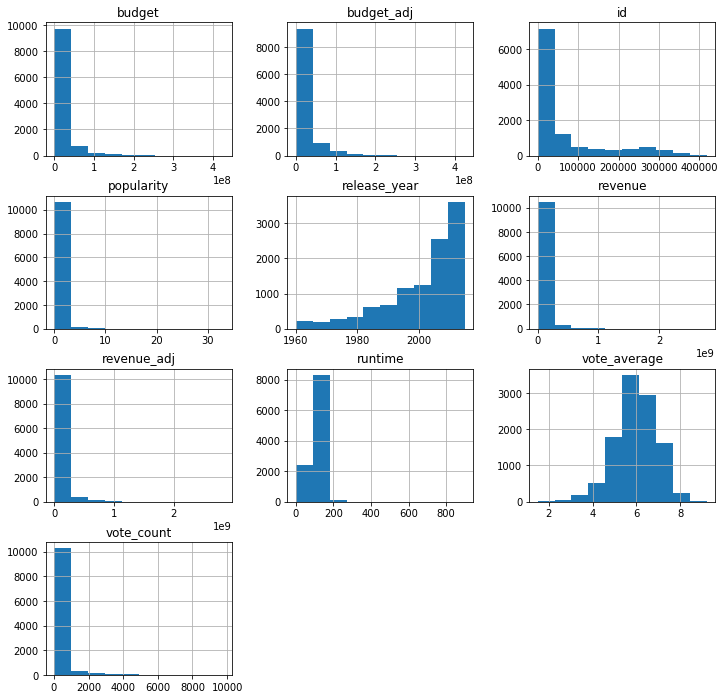

In [8]:
# provide a visual on the distribution of numerical variables
df.hist(figsize=(12,12));

In [9]:
# last not least, let's look for duplicated rows
df.duplicated().sum()

1

#### observations & takeaways:
- there are potential issues in columns **budget**, **revenue**, **budget_adj**, and **revenue_adj**; at least 50% of the values in these columns are 0; I'm assuming that these are missing values since it's highly unlikely that movies can be made with a budget of 0 or that they have 0 revenue; 
- in addition the data in columns **vote_count** and **popularity** are positively skewed with many small values and only a few very large values
- if we decide to use these columns later in the analysis we should be careful to deal with these cases before the analysis
- in contrast, **vote_average** seems well-behaved with a close-to normal distribution
- there is one duplicated row and we will remove it as part of the data cleaning process

### Data Cleaning

#### description of cleaning steps:
- we will remove columns that are not necessary for the analysis
- we will remove duplicate rows
- we will replace 0 values in **budget_adj** and **revenue_adj** with numpy's NaN, so that they will not show up in plots and will not be involved in calculations such as mean or median
- we will create two new dataframes containing information on directors and genres where each row contains only one director or one genre

In [10]:
# in the analysis below we will explore the connection between vote average and different movie parameters
# remove columns that will not be used in our analysis
df.drop(['id','popularity','budget','revenue','cast','homepage','tagline','keywords','overview','runtime','production_companies','release_date'], axis=1, inplace=True)
df.head(3)

,imdb_id,original_title,director,genres,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,tt0369610,Jurassic World,Colin Trevorrow,Action|Adventure|Science Fiction|Thriller,5562,6.5,2015,1.379999e+08,1.392446e+09
1,tt1392190,Mad Max: Fury Road,George Miller,Action|Adventure|Science Fiction|Thriller,6185,7.1,2015,1.379999e+08,3.481613e+08
2,tt2908446,Insurgent,Robert Schwentke,Adventure|Science Fiction|Thriller,2480,6.3,2015,1.012000e+08,2.716190e+08


In [11]:
# remove duplicates from the dataset
df.drop_duplicates(inplace=True)

In [12]:
# replace 0 with NaN in budget_adj and revenue_adj
# these data points will not show up in plots or influence calculations of mean or median
df['budget_adj'] = df['budget_adj'].replace(0, np.nan)
df['revenue_adj'] = df['revenue_adj'].replace(0, np.nan)

In [13]:
# then split genres into lists so that we can search them easily
df.genres = df.genres.str.split('|')
# then explode the lists so that if a movie is associated with multiple genres these now appear as independent rows
df_genres = df.explode('genres')[['imdb_id','genres','vote_average']]

In [14]:
# then split directors into lists so that we can search them easily
df.director = df.director.str.split('|')
# then explode the lists so that if a movie is associated with multiple genres these now appear as independent rows
df_director = df.explode('director')[['imdb_id','director','vote_average']]

In [15]:
# let's have a quick look if the cleanup process worked as wanted
df.head(3)

,imdb_id,original_title,director,genres,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,tt0369610,Jurassic World,[Colin Trevorrow],"[Action, Adventure, Science Fiction, Thriller]",5562,6.5,2015,1.379999e+08,1.392446e+09
1,tt1392190,Mad Max: Fury Road,[George Miller],"[Action, Adventure, Science Fiction, Thriller]",6185,7.1,2015,1.379999e+08,3.481613e+08
2,tt2908446,Insurgent,[Robert Schwentke],"[Adventure, Science Fiction, Thriller]",2480,6.3,2015,1.012000e+08,2.716190e+08


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10865 entries, 0 to 10865
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   imdb_id         10855 non-null  object 
 1   original_title  10865 non-null  object 
 2   director        10821 non-null  object 
 3   genres          10842 non-null  object 
 4   vote_count      10865 non-null  int64  
 5   vote_average    10865 non-null  float64
 6   release_year    10865 non-null  int64  
 7   budget_adj      5169 non-null   float64
 8   revenue_adj     4849 non-null   float64
dtypes: float64(3), int64(2), object(4)
memory usage: 848.8+ KB


In [17]:
df.describe()

,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,10865.000000,10865.000000,10865.000000,5.169000e+03,4.849000e+03
mean,217.399632,5.975012,2001.321859,3.688907e+07,1.151009e+08
std,575.644627,0.935138,12.813260,4.196096e+07,1.988557e+08
min,10.000000,1.500000,1960.000000,9.210911e-01,2.370705e+00
25%,17.000000,5.400000,1995.000000,8.102293e+06,1.046585e+07
50%,38.000000,6.000000,2006.000000,2.271505e+07,4.395666e+07
75%,146.000000,6.600000,2011.000000,5.008384e+07,1.316482e+08
max,9767.000000,9.200000,2015.000000,4.250000e+08,2.827124e+09


<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

### Research Question 1 (Replace this header name!)

In [ ]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.


### Research Question 2  (Replace this header name!)

In [ ]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.


<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed. Make sure that you are clear with regards to the limitations of your exploration. If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work, you should save a copy of the report in HTML or PDF form via the **File** > **Download as** submenu. Before exporting your report, check over it to make sure that the flow of the report is complete. You should probably remove all of the "Tip" quotes like this one so that the presentation is as tidy as possible. Congratulations!